In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
plt.style.use("seaborn")

<ipython-input-1-8696c7a3552a>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [4]:
bankloans = pd.read_csv("/content/bankloans.csv")
bankloans.head()
bankloans.columns
#number of observations and features
bankloans.shape
#data types in the dataframe
bankloans.info()
#check for any column has missing values
bankloans.isnull().any()
#check for number of missing values
bankloans.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     150
dtype: int64

In [5]:
#Segregating the numeric and categorical variable names
numeric_var_names = [key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
catgorical_var_names = [key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]
numeric_var_names
#splitting the data set into two sets - existing customers and new customers
bankloans_existing = bankloans.loc[bankloans.default.isnull() == 0]

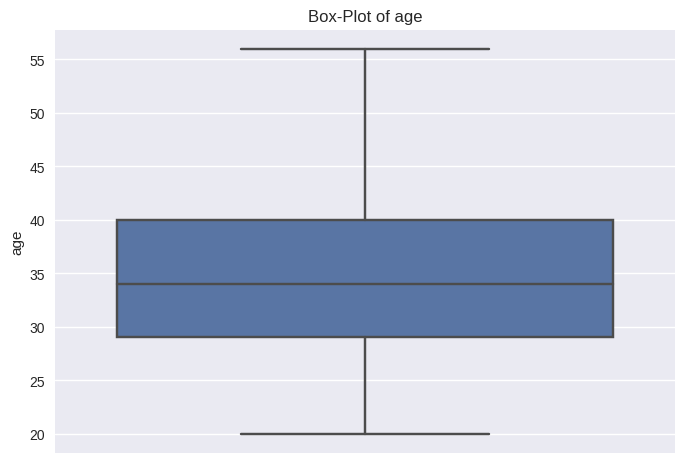

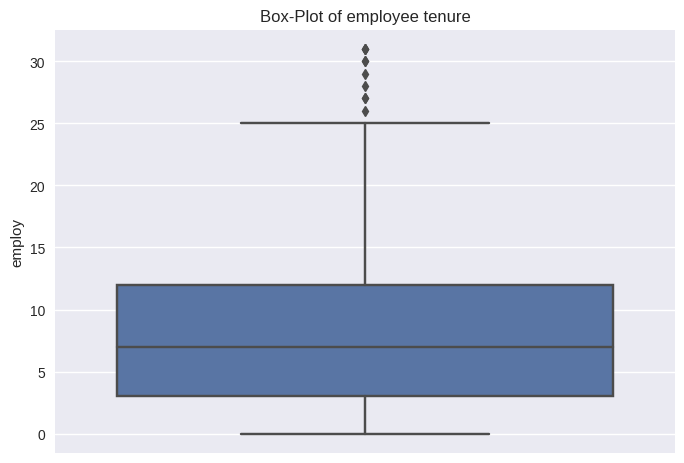

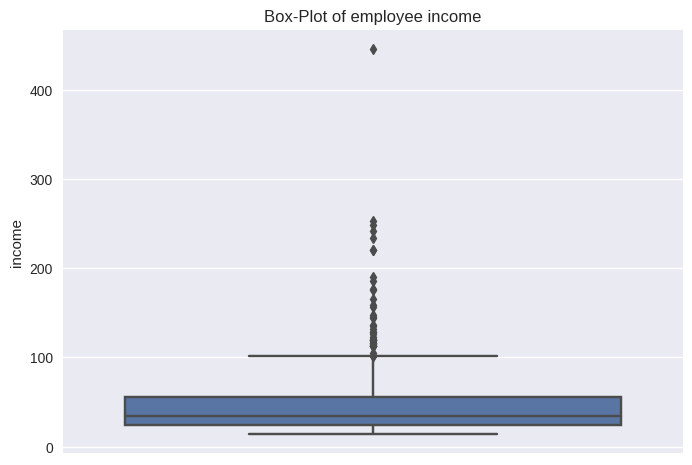

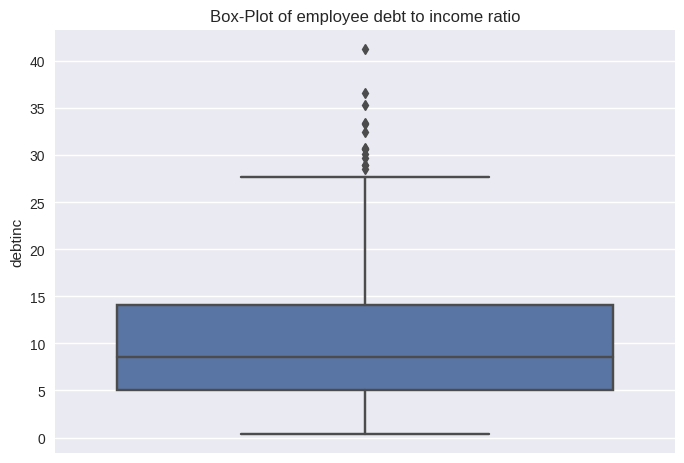

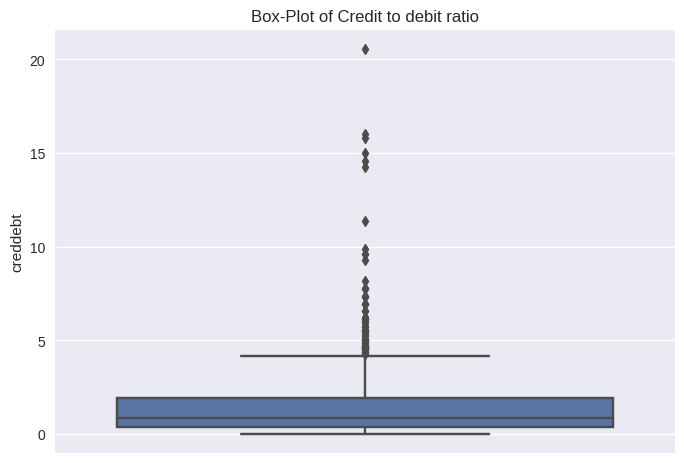

In [6]:
bankloans_new = bankloans.loc[bankloans.default.isnull() == 1]
bankloans_existing.describe(percentiles=[.25,0.5,0.75,0.90,0.95])
sns.boxplot(y = "age",data=bankloans_existing)
plt.title("Box-Plot of age")
plt.show()
sns.boxplot(y = "employ",data=bankloans_existing)
plt.title("Box-Plot of employee tenure")
plt.show()
sns.boxplot(y = "income",data=bankloans_existing)
plt.title("Box-Plot of employee income")
plt.show()
sns.boxplot(y = "debtinc",data=bankloans_existing)
plt.title("Box-Plot of employee debt to income ratio")
plt.show()
sns.boxplot(y = "creddebt",data=bankloans_existing)
plt.title("Box-Plot of Credit to debit ratio")
plt.show()

In [7]:
income_minlimit = bankloans_existing["income"].quantile(0.75) + 1.5 * (bankloans_existing["income"].quantile(0.75) - bankloans_existing["income"].quantile(0.25))
income_minlimit
def outlier_capping(x):
  x = x.clip_upper(x.quantile(0.95))
  return(x)

In [11]:
bankloans_existing.corr()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
age,1.000000,0.022325,0.536497,0.597591,0.478710,0.016398,0.295207,0.340217,-0.137657
ed,0.022325,1.000000,-0.153621,0.056919,0.235190,0.008838,0.088274,0.165459,0.114676
employ,0.536497,-0.153621,1.000000,0.322334,0.619681,-0.031182,0.403694,0.406091,-0.282978
address,0.597591,0.056919,0.322334,1.000000,0.316245,0.011323,0.208435,0.226514,-0.164451
income,0.478710,0.235190,0.619681,0.316245,1.000000,-0.026777,0.570199,0.610659,-0.070970
debtinc,0.016398,0.008838,-0.031182,0.011323,-0.026777,1.000000,0.501767,0.584870,0.389575
creddebt,0.295207,0.088274,0.403694,0.208435,0.570199,0.501767,1.000000,0.633104,0.244740
othdebt,0.340217,0.165459,0.406091,0.226514,0.610659,0.584870,0.633104,1.000000,0.145713
default,-0.137657,0.114676,-0.282978,-0.164451,-0.070970,0.389575,0.244740,0.145713,1.000000


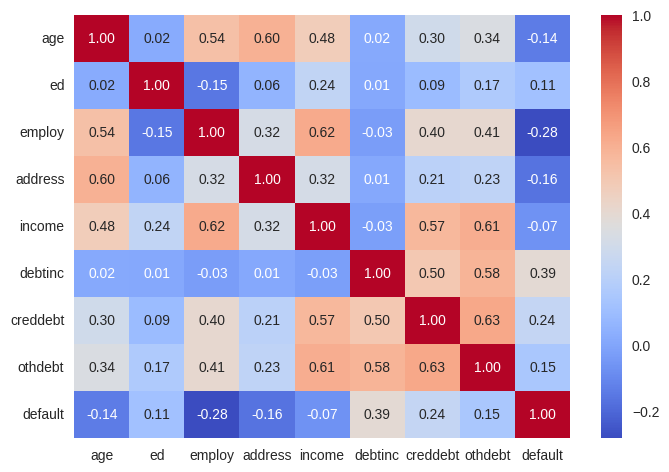

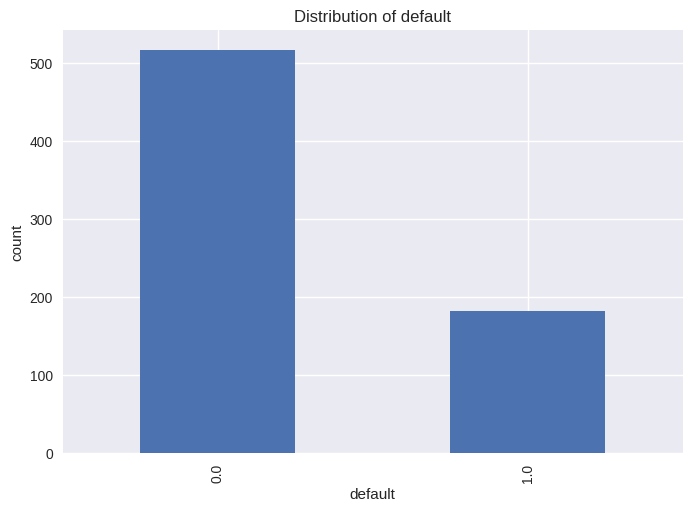

In [13]:
sns.heatmap(bankloans_existing.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()
bankloans_existing.shape
bankloans_new.shape
#Indicator variable unique types
bankloans_existing['default'].value_counts()
bankloans_existing['default'].value_counts().plot.bar()
plt.xlabel("default")
plt.ylabel("count")
plt.title("Distribution of default")
plt.show()

In [15]:
  #percentage of unique types in indicator variable
  round(bankloans_existing['default'].value_counts()/bankloans_existing.shape[0] * 100,3)
  ## performing the independent t test on numerical variables
  tstats_df = pd.DataFrame()
  for eachvariable in numeric_var_names:
     tstats = stats.ttest_ind(bankloans_existing.loc[bankloans_existing["default"] == 1,eachvariable],bankloans_existing.loc[bankloans_existing["default"] == 0, eachvariable],equal_var=False)
     temp = pd.DataFrame([eachvariable, tstats[0], tstats[1]]).T
     temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
     tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)
     tstats_df = tstats_df.sort_values(by = "P-Value").reset_index(drop = True)
     tstats_df

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [19]:
def BivariateAnalysisPlot(segment_by):
  fig, ax = plt.subplots(ncols=1,figsize = (10,8))
#boxplot
  sns.boxplot(x = 'default', y = segment_by, data=bankloans_existing)
  plt.title("Box plot of "+segment_by)
  plt.show()
  BivariateAnalysisPlot("age")
  BivariateAnalysisPlot("ed")
  BivariateAnalysisPlot("employ")
  BivariateAnalysisPlot("address")
  BivariateAnalysisPlot("income")
  BivariateAnalysisPlot("debtinc")
  BivariateAnalysisPlot("creddebt")
  BivariateAnalysisPlot("othdebt")

In [26]:
decisiontree_hyperparameters = {
'decisiontreeclassifier__max_depth' : np.arange(3, 10),
'decisiontreeclassifier__max_features' : np.arange(3, 8),
'decisiontreeclassifier__min_samples_split' : np.arange(2, 15),
"decisiontreeclassifier__min_samples_leaf" : np.arange(1,3)
}

In [28]:
dtclass_model = GridSearchCV(pipelines['dtclass'],decisiontree_hyperparameters,cv=5, n_jobs=-1)
#fit the model
